# Week 5 - Classifying Meanings & Documents

Recall that Week 1 of this course focused on how to find and extract text data, while weeks 2 through 4 each covered a different type of content representations:

2. computational linguistics (e.g., keyword count)
3. clustering and topic modeling (e.g., LDA)
4. embeddings (e.g., _word2vec_)

Now we show how classification, arguably the most common social science task, can be done with different representations. Note that the second representation, *clustering*, allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. Classification, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

We will show how to use a variety of classification methods, including Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

In [2]:
!pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-z_smxir1
  Running command git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-z_smxir1


In [3]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
# import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Annotations

This is a course on "computational" content analysis, but the best computer today is arguably still the human brain. Our aim is to augment human intelligence and scholarship. One of the most important strategies is to have real, live _Homo sapiens_ annotate text, assigning numbers or categories to individual texts. We can computationally compare annotations across humans, and we can use annotations to train computational models.

Let's take a quick look at Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" style="width:500px">

In [8]:
# Remember if you are on Google Colab, you need to upload or `git clone` the datafile
# and your path will probably be something like "#content/drive/MyDrive//data/pyAnno/testdata_numerical.txt"
x = np.loadtxt("/content/drive/MyDrive/Colab Notebooks/data/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Interrogate the AnnotationsContainer object.

In [9]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [10]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [11]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [12]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


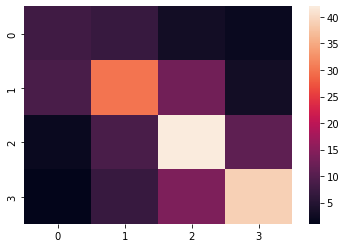

In [13]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [14]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [15]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [16]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [17]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [18]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


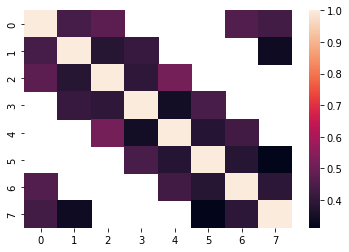

In [19]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [20]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [21]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [22]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

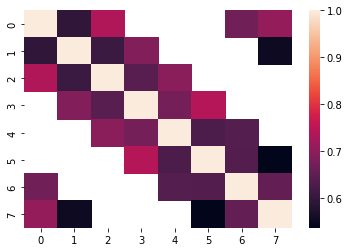

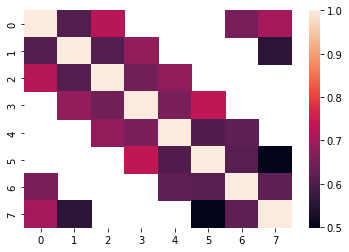

In [23]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [24]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <font color="red">*Exercise 1*</font>

<font color="red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the [MTurk slides on Canvas](https://canvas.uchicago.edu/courses/39937/files/6674661?wrap=1), or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

In [12]:
df_sample = pandas.read_pickle("/content/drive/MyDrive/Colab Notebooks/data/survey_data/financial_news.pkl")

In [13]:
df_sample

,Date,Company,Title,Article,System_GMT_Time,Display_ET_Time,Accession_Number,participant1
0,20200401,None,\nNews Highlights: Top Energy News of the Day,\n\n \nOil Rallies But Still Posts Historic Ma...,20200401T040012.298Z,"April 01, 2020 00:00 ET (04:00 GMT)",20200401000002,NaN
1,20200401,None,\nNews Highlights: Top Financial Services News...,\n\n \nEurope's Banks Urged to Cut Dividends t...,20200401T040012.798Z,"April 01, 2020 00:00 ET (04:00 GMT)",20200401000003,NaN
2,20200401,\nUKDAY\n,\nEuropean Morning Briefing: Stock Futures Sli...,\n\n \nSnapshot: \n======== \n\n Stocks seen ...,20200401T040014.736Z,"April 01, 2020 00:00 ET (04:00 GMT)",20200401000004,NaN
3,20200401,\n7270.TO\nFUJHY\n,\nSubaru: Temporary Suspension to Affect Sever...,\n\n \n\n (MORE TO FOLLOW) Dow Jones Newswire...,20200401T040121.913Z,"April 01, 2020 00:01 ET (04:01 GMT)",20200331017795,NaN
4,20200401,\n000488.SZ\n1812.HK\n,\nHK Bourse: Announcement From Shandong Chenmi...,"\n\n \n For full details, please click on t...",20200401T040204.720Z,"April 01, 2020 00:02 ET (04:02 GMT)",20200401000008,NaN
...,...,...,...,...,...,...,...,...
95,20200401,\n0653.HK\n,\nHK Bourse: Results Announcement From Bonjour...,"\n\n \n For full details, please click on t...",20200401T041651.825Z,"April 01, 2020 00:16 ET (04:16 GMT)",20200401000109,NaN
96,20200401,None,\nIndonesia Mar Core Inflation +2.87% On Year ...,\n\n \n\n (MORE TO FOLLOW) Dow Jones Newswire...,20200401T041753.081Z,"April 01, 2020 00:17 ET (04:17 GMT)",20200401000079,NaN
97,20200401,None,\nChina Manufacturing PMI Unlikely to Stay Abo...,\n\n 0418 GMT - China's manufacturing PMI ...,20200401T041905.742Z,"April 01, 2020 00:19 ET (04:19 GMT)",20200401000111,NaN
98,20200401,\n1047.HK\n,\nHK Bourse: Announcement From Ngai Hing Hong ...,\n\n \n Following is the related link: \nht...,20200401T041909.812Z,"April 01, 2020 00:19 ET (04:19 GMT)",20200401000114,NaN


Based on this sample data, I design a content annotation survey study with three participants. Sincere thanks to Qiuyu Li, Zimei Xia and Yawen Zhang! The basic idea is to determine whether the sentiment conveyed through the articles are postive (+1), negative (0) or unknown sentiment/neutral (-1). Survey participants will use their common knowledge to determine the sentiment as a proxy for the market, regardless of their own risk preference.

In [14]:
data_qiuyu = pandas.read_csv('/content/drive/MyDrive/Colab Notebooks/data/survey_data/financial_news_qiuyu.csv')  
data_zimei = pandas.read_csv('/content/drive/MyDrive/Colab Notebooks/data/survey_data/financial_news_zimei.csv')  
data_yawen = pandas.read_csv('/content/drive/MyDrive/Colab Notebooks/data/survey_data/financial_news_yawen.csv')  

In [15]:
survey_data = data_qiuyu
survey_data['participant2'] = data_zimei['participant1']
survey_data['participant3'] = data_yawen['participant1']
#survey_data = survey_data.replace(0,-2)
#survey_data = survey_data.replace(-1,0)
#survey_data = survey_data.replace(-2,-1)
survey_data = survey_data.fillna(-1)
survey_data

,Unnamed: 0,Date,Company,Title,Article,System_GMT_Time,Display_ET_Time,Accession_Number,participant1,participant2,participant3
0,0,20200401,-1,\nNews Highlights: Top Energy News of the Day,\n\n \nOil Rallies But Still Posts Historic Ma...,20200401T040012.298Z,"April 01, 2020 00:00 ET (04:00 GMT)",2.020000e+13,-1.0,1.0,0.0
1,1,20200401,-1,\nNews Highlights: Top Financial Services News...,\n\n \nEurope's Banks Urged to Cut Dividends t...,20200401T040012.798Z,"April 01, 2020 00:00 ET (04:00 GMT)",2.020000e+13,-1.0,0.0,0.0
2,2,20200401,\nUKDAY\n,\nEuropean Morning Briefing: Stock Futures Sli...,\n\n \nSnapshot: \n======== \n\n Stocks seen ...,20200401T040014.736Z,"April 01, 2020 00:00 ET (04:00 GMT)",2.020000e+13,0.0,1.0,-1.0
3,3,20200401,\n7270.TO\nFUJHY\n,\nSubaru: Temporary Suspension to Affect Sever...,\n\n \n\n (MORE TO FOLLOW) Dow Jones Newswire...,20200401T040121.913Z,"April 01, 2020 00:01 ET (04:01 GMT)",2.020000e+13,0.0,-1.0,0.0
4,4,20200401,\n000488.SZ\n1812.HK\n,\nHK Bourse: Announcement From Shandong Chenmi...,"\n\n \n For full details, please click on t...",20200401T040204.720Z,"April 01, 2020 00:02 ET (04:02 GMT)",2.020000e+13,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
95,95,20200401,\n0653.HK\n,\nHK Bourse: Results Announcement From Bonjour...,"\n\n \n For full details, please click on t...",20200401T041651.825Z,"April 01, 2020 00:16 ET (04:16 GMT)",2.020000e+13,-1.0,0.0,1.0
96,96,20200401,-1,\nIndonesia Mar Core Inflation +2.87% On Year ...,\n\n \n\n (MORE TO FOLLOW) Dow Jones Newswire...,20200401T041753.081Z,"April 01, 2020 00:17 ET (04:17 GMT)",2.020000e+13,1.0,-1.0,1.0
97,97,20200401,-1,\nChina Manufacturing PMI Unlikely to Stay Abo...,\n\n 0418 GMT - China's manufacturing PMI ...,20200401T041905.742Z,"April 01, 2020 00:19 ET (04:19 GMT)",2.020000e+13,0.0,0.0,0.0
98,98,20200401,\n1047.HK\n,\nHK Bourse: Announcement From Ngai Hing Hong ...,\n\n \n Following is the related link: \nht...,20200401T041909.812Z,"April 01, 2020 00:19 ET (04:19 GMT)",2.020000e+13,-1.0,-1.0,1.0


In [115]:
anno = survey_data[["participant1","participant2","participant3"]].values
anno = anno.astype(int)
survey_anno = AnnotationsContainer.from_array(anno,missing_values=[-1])


In [116]:
survey_anno.annotations

array([[-1,  1,  0],
       [-1,  0,  0],
       [ 0,  1, -1],
       [ 0, -1,  0],
       [-1, -1, -1],
       [ 0,  1, -1],
       [-1, -1,  1],
       [ 0,  0,  1],
       [ 0,  0,  0],
       [ 1,  1,  1],
       [ 0,  0,  0],
       [-1,  1,  0],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  0,  0],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  

In [117]:
survey_anno.labels

[0, 1]

In [126]:
survey_anno.missing_values

[-1]

In [127]:
pyanno.measures.agreement.labels_frequency(anno,2)

array([0.32214765, 0.67785235])

[[6. 5.]
 [0. 7.]]


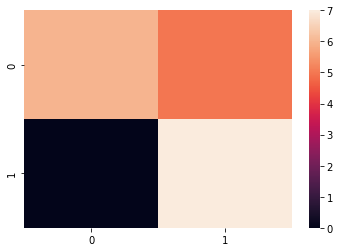

In [128]:
c = pyanno.measures.agreement.confusion_matrix(anno[:,0], anno[:,1],2)
print(c)
ac = seaborn.heatmap(c)
plt.show()

In [129]:
scotts_pi(survey_anno.annotations[:,0], survey_anno.annotations[:,1])

0.3361810772327786

In [135]:
krippendorffs_alpha(survey_anno.annotations)

0.28533094812164583

In [143]:
cohens_kappa(survey_anno.annotations[:,0], survey_anno.annotations[:,1])

0.5209262800084979

In [145]:
m = pairwise_matrix(cohens_kappa, survey_anno.annotations)
print(m)

[[1.         0.52092628 0.33823529]
 [0.52092628 1.         0.19769924]
 [0.33823529 0.19769924 1.        ]]


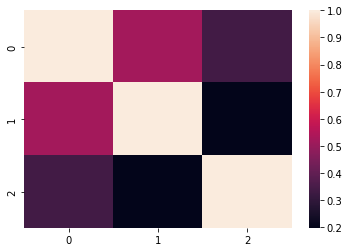

In [146]:
ax = seaborn.heatmap(m)
plt.show()

In [148]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, survey_anno.annotations)

0.35228693837095415

In [149]:
cohens_weighted_kappa(survey_anno.annotations[:,0], survey_anno.annotations[:,1])

0.5209262800084979

In [150]:
pairwise_metric_average(cohens_weighted_kappa,survey_anno.annotations)

0.3522869383709541

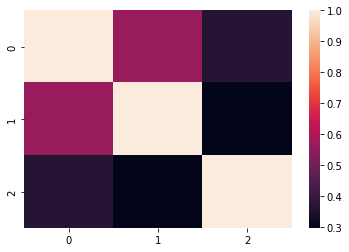

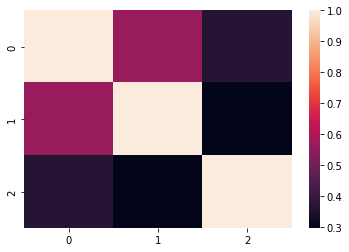

In [151]:
n = pairwise_matrix(pearsons_rho, survey_anno.annotations)
m = pairwise_matrix(spearmans_rho, survey_anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

In [152]:
print(pairwise_metric_average(pearsons_rho,survey_anno.annotations), pairwise_metric_average(spearmans_rho,survey_anno.annotations))

0.40949677680949076 0.4094967768094908


According to the most common metric of agreement - Cohen's $\kappa$ statistic, the degree of agreement among the three annotators is 0.5209262800084979. We can see the power of human intelligence in this survey.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

We use the popular `train_test_split()` function from `sklearn`, and the data pattern function source code is copied below for your convenience from `lucem_illud`'s [cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py) file.

In [159]:
def random(noise = 0, numPerCategory = 500):
    datDict = {
        'vect' : [np.random.rand(2) * 2 - 1 for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def andSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        y = np.random.random_sample() * 2 - 1
        if noise >= 0:
            x = np.random.random_sample() - cat - (np.random.random_sample() - cat) * noise
        else:
            x = (1 - noise * np.random.random_sample()) - cat
        return np.array([x, y])
    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def xorSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        if cat == 1:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        else:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        return np.array([x, y])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def targetSplit(noise = 0, numPerCategory = 500, innerRad = .3):
    def genPoint(cat):
        if cat == 0:
            r = np.random.random_sample() * innerRad + (1 - innerRad) * np.random.random_sample() * noise
        else:
            r = np.random.random_sample() * (1 - innerRad) + innerRad - innerRad * np.random.random_sample() * noise
        eta = 2 * np.pi * np.random.random_sample()
        return np.array([r * np.cos(eta), r * np.sin(eta)])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def multiBlobs(noise = 0, numPerCategory = 500, centers = 5):
    if isinstance(centers, int):
        n_samples = numPerCategory * centers
    else:
        n_samples = numPerCategory * len(centers)
    X, y = sklearn.datasets.make_blobs(n_samples=n_samples, centers=centers, cluster_std = (.8 * (noise * 2 + 1)))
    datDict = {
        'vect' : list(X),
        'category' : y,
    }
    return pandas.DataFrame(datDict)

In [160]:
noise = .2

#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.random(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)

We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

In [49]:
dfTrain

,vect,category
991,"[-0.3123382676951598, -0.8031884793068715]",1
4,"[-0.03189248881043446, -0.2452928089035536]",0
693,"[0.09276975509419348, 0.8219747099349319]",1
200,"[-0.228548240456407, 0.18961562094581547]",0
646,"[0.005088576165031897, -0.2639302557542684]",0
...,...,...
605,"[-0.18696503862663644, 0.8046302489462878]",1
198,"[0.08760420380425799, -0.25088086054659214]",0
217,"[0.3305353676700231, -0.31859711451094824]",1
13,"[-0.3649141950104557, -0.1023348780472761]",1


So, dfTrain has two columns, vect and category. We can plot this with `plotter()` from [lucem_illud/lucem_illud/cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py). Here's the source code:

In [50]:
def plotter(df):
    fig, ax = plt.subplots(figsize = (10,10))
    pallet = seaborn.color_palette(palette='rainbow', n_colors= len(set(df['category'])))
    for i, cat in enumerate(set(df['category'])):
        a = np.stack(df[df['category'] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    ax.axis('off')
    plt.show()
    plt.close()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


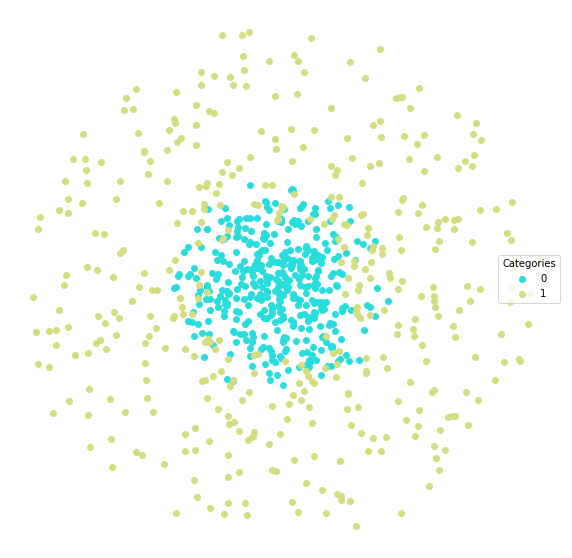

In [51]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [52]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

We're using sklearn here. What is sklearn? It's an open source machine learning library for Python. We use sklearn because it features various machine learning algorithms and it works well with NumPy library. You don't need to understand the sklearn package in detail for the moment, but let's see what methods and attributes sklearn has, because we're going to use some of them:

In [53]:
dir(sklearn)

['__SKLEARN_SETUP__',
 '__all__',
 '__builtins__',
 '__cached__',
 '__check_build',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_config',
 '_distributor_init',
 '_loss',
 'base',
 'clone',
 'config_context',
 'datasets',
 'decomposition',
 'dummy',
 'ensemble',
 'exceptions',
 'externals',
 'feature_extraction',
 'get_config',
 'linear_model',
 'logger',
 'logging',
 'metrics',
 'model_selection',
 'neighbors',
 'neural_network',
 'os',
 'preprocessing',
 'random',
 'set_config',
 'setup_module',
 'show_versions',
 'svm',
 'sys',
 'tree',
 'utils']

Now we fit the model by giving it our training data

In [54]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

KNeighborsClassifier(weights='distance')

Here, "stack" function is used. Why did we use stack function here? This is because dfTrain['vect'] is a sequence, while clf.fit() takes an array element. Let's see what dfTrain['vect'] looks like:

In [55]:
dfTrain['vect']

991     [-0.3123382676951598, -0.8031884793068715]
4      [-0.03189248881043446, -0.2452928089035536]
693      [0.09276975509419348, 0.8219747099349319]
200      [-0.228548240456407, 0.18961562094581547]
646    [0.005088576165031897, -0.2639302557542684]
                          ...                     
605     [-0.18696503862663644, 0.8046302489462878]
198    [0.08760420380425799, -0.25088086054659214]
217     [0.3305353676700231, -0.31859711451094824]
13      [-0.3649141950104557, -0.1023348780472761]
221      [-0.5436401960160526, 0.7591650811514005]
Name: vect, Length: 800, dtype: object

And let's see what np.stack(dfTrain['vect']) does:

In [56]:
np.stack(dfTrain['vect'])

array([[-0.31233827, -0.80318848],
       [-0.03189249, -0.24529281],
       [ 0.09276976,  0.82197471],
       ...,
       [ 0.33053537, -0.31859711],
       [-0.3649142 , -0.10233488],
       [-0.5436402 ,  0.75916508]])

As you can see, stack function takes a sequence of arrays (which have the same shape) and joins them along a new axis.

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set. These `lucem_illud` functions are in [metrics.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/metrics.py), and we will skip copying source code this time due to length.

In [57]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.115,0.885488,0.902913,0.857178,0.877358
1,0.115,0.885488,0.865979,0.823854,0.893617


This lets us look at which classes do better:

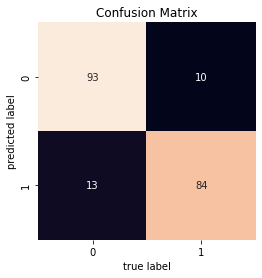

In [58]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

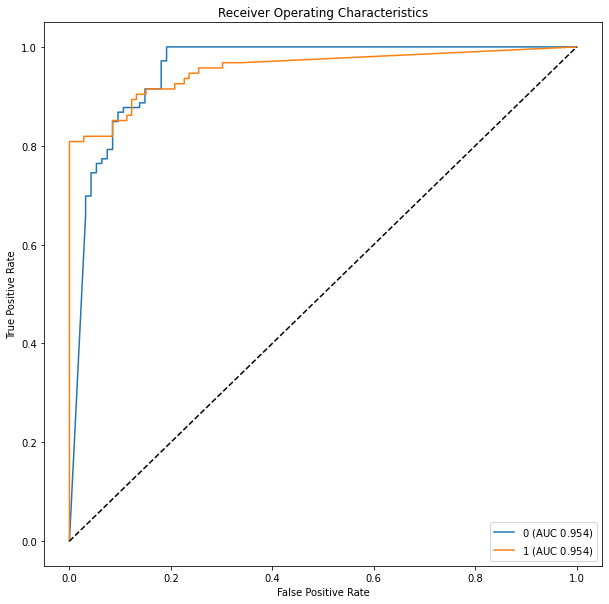

In [59]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


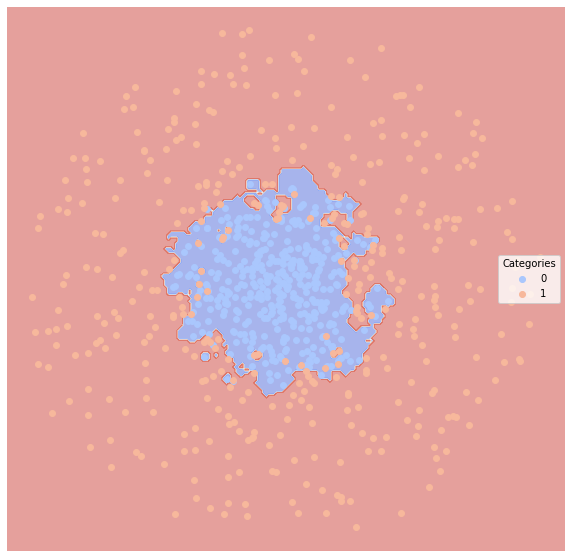

In [60]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [161]:
# Rewrite lucem_illud
import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import IPython.display #For displaying images

import os #For looking through files
import os.path #For managing file paths
import re
import tarfile

import zipfile
import sys

from lucem_illud.processing import normalizeTokens, trainTestSplit, word_tokenize, sent_tokenize

dataDirectory = "/content/drive/MyDrive/Colab Notebooks/data/"

def loadTextDirectory(targetDir, encoding = 'utf-8'):
    text = []
    fileName = []

    for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
        with open(file.path, encoding = encoding) as f:
            text.append(f.read())
        fileName.append(file.name)
    return pandas.DataFrame({'text' : text}, index = fileName)

def loadDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into useable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    #The dict that will become the DataFrame
    senDict = {
        'category' : [category] * len(filePaths),
        'filePath' : [],
        'text' : [],
    }

    for fPath in filePaths:
        with open(fPath) as f:
            senDict['text'].append(f.read())
            senDict['filePath'].append(fPath)

    return pandas.DataFrame(senDict)


def _loadEmailZip(targetFile, category):
    # regex for stripping out the leading "Subject:" and any spaces after it
    subject_regex = re.compile(r"^Subject:\s+")

    #The dict that will become the DataFrame
    emailDict = {
        'category' : [],
        'text' : [],
    }
    with tarfile.open(targetFile) as tar:
        for tarinfo in tar.getmembers():
            if tarinfo.isreg():
                with tar.extractfile(tarinfo) as f:
                    s = f.read().decode('latin1', 'surrogateescape')
                    for line in s.split('\n'):
                        if line.startswith("Subject:"):
                            #Could also save the subject field
                            subject = subject_regex.sub("", line).strip()
                            emailDict['text'].append(subject)
    emailDict['category'] = [category] * len(emailDict['text'])
    return pandas.DataFrame(emailDict)

def generateVecs(df, sents = False):
    df['tokenized_text'] = df['text'].apply(lambda x: word_tokenize(x))
    df['normalized_text'] = df['tokenized_text'].apply(lambda x: normalizeTokens(x))

    if sents:
        df['tokenized_sents'] = df['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
        df['normalized_sents'] = df['tokenized_sents'].apply(lambda x: [normlizeTokens(s) for s in x])

    ngCountVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
    newsgroupsVects = ngCountVectorizer.fit_transform([' '.join(l) for l in df['normalized_text']])
    df['vect'] = [np.array(v).flatten() for v in newsgroupsVects.todense()]
    return df

def loadNewsGroups(categories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos'], dataDirectory=dataDirectory):
    newsgroupsCategories = categories
    newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = dataDirectory)
    newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

    for category in newsgroupsCategories:
        print("Loading data for: {}".format(category))
        ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = dataDirectory)
        newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

    print("Converting to vectors")
    return generateVecs(newsgroupsDF)

def loadSenateSmall(dataDirectory=dataDirectory):
    print("Loading senate data")
    senReleasesDF = pandas.read_csv('/content/drive/MyDrive/Colab Notebooks/data/ObamaClintonReleases.csv', index_col=0)
    senReleasesDF = senReleasesDF.dropna(axis=0, how='any')

    senReleasesDF['category'] = senReleasesDF['targetSenator']
    print("Converting to vectors")
    return generateVecs(senReleasesDF)

def loadSenateLarge(dataDirectory=dataDirectory):
    dataDir = os.path.join(dataDirectory, 'grimmerPressReleases')
    senReleasesDF = pandas.DataFrame()

    for senatorName in [d for d in os.listdir(dataDir) if d[0] != '.']:
        print("Loading senator: {}".format(senatorName))
        senPath = os.path.join(dataDir, senatorName)
        senReleasesDF = senReleasesDF.append(loadDir(senPath, senatorName), ignore_index = True)

    print("Converting to vectors")
    return generateVecs(senReleasesDF)

def loadSpam(holdBackFraction = .2, dataDirectory=dataDirectory):
    print("Loading Spam")
    spamDF = _loadEmailZip(os.path.join(dataDirectory,'Spam_Data/20021010_spam.tar.bz2'), 'spam')
    print("Loading Ham")
    spamDF = spamDF.append(_loadEmailZip(os.path.join(dataDirectory,'Spam_Data/20021010_hard_ham.tar.bz2'), 'not spam'), ignore_index= True)
    spamDF = spamDF.append(_loadEmailZip(os.path.join(dataDirectory,'Spam_Data/20021010_easy_ham.tar.bz2'), 'not spam'), ignore_index= True)
    spamDF['is_spam'] = [c == 'spam' for c in spamDF['category']]
    spamDF['binary'] = spamDF['is_spam']

    print("Converting to vectors")
    return generateVecs(spamDF)

def loadReddit(holdBackFraction = .2, dataDirectory=dataDirectory):
    print("Loading Reddit data")
    redditDf = pandas.read_csv(os.path.join(dataDirectory,'reddit.csv'))
    redditDf = redditDf.dropna()
    redditDf['category'] = [s.split(':')[0] for s in redditDf['subreddit']]
    print("Converting to vectors")
    return generateVecs(redditDf)


def loadDavies(address, corpus_style="text", num_files=10000, return_raw=False):
    texts_raw = {}
    for file in os.listdir(address + "/"):
        if corpus_style in file:
            print(file)
            zfile = zipfile.ZipFile(address + "/" + file)
            for file in zfile.namelist():
                texts_raw[file] = []
                with zfile.open(file) as f:
                    for line in f:
                        texts_raw[file].append(line)

    if return_raw:
        return(texts_raw)

    tokenized_texts = {}
    for files in texts_raw:
        if len(tokenized_texts) > num_files:
            break
        texts = clean_raw_text(texts_raw[files][1:])
        for text in texts:
            txts = word_tokenize(text)
            try:
                tokenized_texts[txts[0][2:]] = txts[1:]
            except IndexError:
                continue
    return tokenized_texts

def clean_raw_text(texts_raw):
    clean_texts = []
    for text in texts_raw:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts


In [176]:
dfTrain11, dfTest11 = sklearn.model_selection.train_test_split(loadReddit(), test_size=.2)
dfTrain12, dfTest12 = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.2)
dfTrain13, dfTest13 = sklearn.model_selection.train_test_split(loadSenateSmall(), test_size=.2)
dfTrain14, dfTest14 = sklearn.model_selection.train_test_split(loadSenateLarge(), test_size=.2)
dfTrain15, dfTest15 = sklearn.model_selection.train_test_split(loadSpam(), test_size=.2)

Loading Reddit data
Converting to vectors
Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors
Loading senate data
Converting to vectors
Loading senator: Klobuchar
Loading senator: Kohl
Loading senator: Kerry
Loading senator: Kennedy
Loading senator: Kyl
Converting to vectors
Loading Spam
Loading Ham
Converting to vectors


In [65]:
#Classical Regression
clf = sklearn.linear_model.LogisticRegression()

#Bayes
# clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [66]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

LogisticRegression()

In [67]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Relationships,0.01250,0.977697,0.986111,0.955509,0.959459
Bad Roommates,0.01250,0.982421,0.972973,0.952926,0.972973
Tales From Tech Support,0.00625,0.995763,0.976744,0.976744,1.000000
Weeaboo Tales,0.00625,0.992163,0.988636,0.980527,0.988636


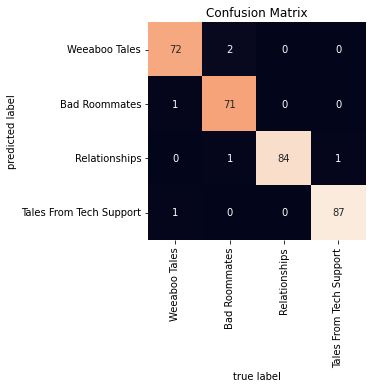

In [68]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

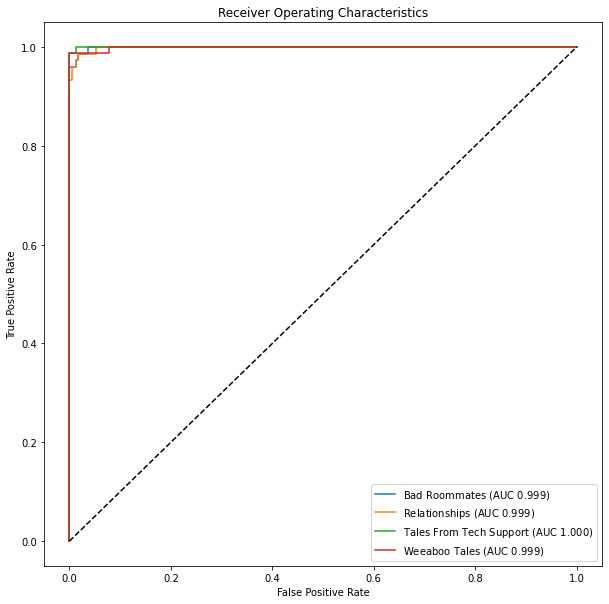

In [69]:
lucem_illud.plotMultiROC(clf, dfTest)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

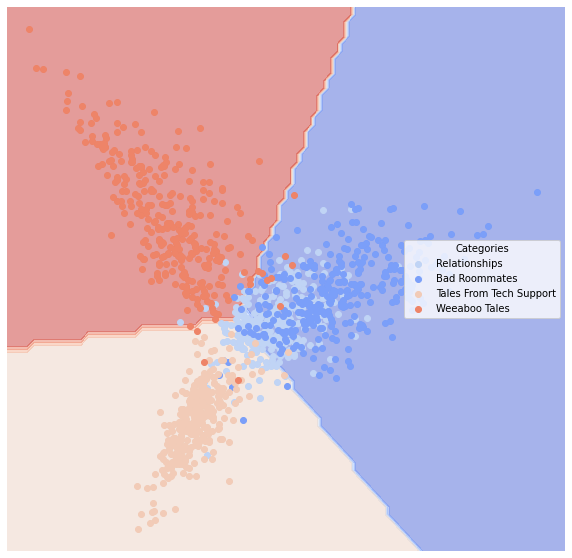

In [70]:
lucem_illud.plotregions(clf, dfTrain)

## <font color="red">*Exercise 2*</font>

<font color="red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<font color="red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

In [182]:
noise = .2

dfTrain1, dfTest1 = sklearn.model_selection.train_test_split(random(noise), test_size=.2)
dfTrain2, dfTest2 = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
dfTrain3, dfTest3 = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
dfTrain4, dfTest4 = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
dfTrain5, dfTest5 = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)

dfTrain6, dfTest6 = sklearn.model_selection.train_test_split(random(noise), test_size=.2)
dfTrain7, dfTest7 = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
dfTrain8, dfTest8 = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
dfTrain9, dfTest9 = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
dfTrain10, dfTest10 = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)

In [72]:
dfTrain1

,vect,category
793,"[-0.46446087058586394, -0.30284594107493645]",1
640,"[0.6497550525729014, -0.6474664077909029]",0
28,"[0.10843977465775478, 0.8725810893736601]",0
430,"[0.7114740480542712, 0.32747395286616654]",0
371,"[-0.8505519044291578, -0.35110159059901225]",1
...,...,...
913,"[-0.9183396860105093, 0.893770440190421]",1
895,"[-0.46744061456300146, -0.766528359099901]",1
286,"[0.39784226213672746, -0.7087171044713179]",0
228,"[-0.3111943426677788, -0.47110058983135605]",0


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


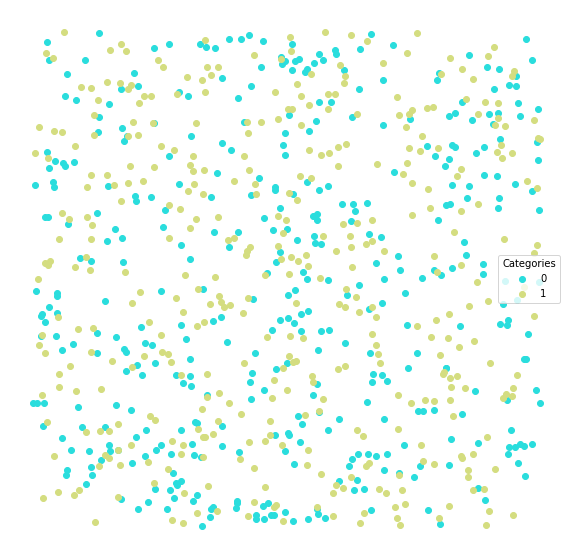

In [73]:
lucem_illud.plotter(dfTrain1)

In [163]:
#Bayes
import sklearn.naive_bayes
clf1 = sklearn.naive_bayes.GaussianNB()

#Analogizes
clf2 = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
clf3 = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf4 = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
clf5 = sklearn.linear_model.LogisticRegression()

#Symbolists
clf6 = sklearn.tree.DecisionTreeClassifier()
clf7 = sklearn.ensemble.RandomForestClassifier()

#Connectionists
clf8 = sklearn.neural_network.MLPClassifier()

#Ensemble
clf9 = sklearn.ensemble.GradientBoostingClassifier()

In [75]:
# Training for dataset 1
clf1.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
clf2.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
clf3.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
clf4.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
clf5.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
clf6.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
clf7.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
clf8.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
clf9.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])

GradientBoostingClassifier()

In [76]:
df_cartoon = pandas.DataFrame()
for i in range(1,10):
  df_cartoon = df_cartoon.append(lucem_illud.evaluateClassifier(globals()['clf%s' % i], dfTest1).iloc[0,:], ignore_index=True)

In [77]:
df_cartoon

,Error_Rate,AUC,Precision,Average_Precision,Recall
0,0.375,0.624512,0.633333,0.574646,0.575758
1,0.395,0.604910,0.602041,0.558792,0.595960
2,0.490,0.511051,0.504132,0.500627,0.616162
3,0.470,0.529853,0.525773,0.510853,0.515152
4,0.375,0.624912,0.622449,0.573529,0.616162
5,0.465,0.535204,0.528846,0.513803,0.555556
6,0.475,0.524902,0.520408,0.508089,0.515152
7,0.430,0.569757,0.568421,0.535048,0.545455
8,0.490,0.509151,0.506024,0.499677,0.424242


In [78]:
df_cartoon.sort_values('AUC')

,Error_Rate,AUC,Precision,Average_Precision,Recall
8,0.490,0.509151,0.506024,0.499677,0.424242
2,0.490,0.511051,0.504132,0.500627,0.616162
6,0.475,0.524902,0.520408,0.508089,0.515152
3,0.470,0.529853,0.525773,0.510853,0.515152
5,0.465,0.535204,0.528846,0.513803,0.555556
7,0.430,0.569757,0.568421,0.535048,0.545455
1,0.395,0.604910,0.602041,0.558792,0.595960
0,0.375,0.624512,0.633333,0.574646,0.575758
4,0.375,0.624912,0.622449,0.573529,0.616162


We can notice that the GradientBoostingClassifier generates the highest AUC and is therefore works best with artificial dataset 1.

In [79]:
# Training for dataset 2
clf1.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
clf2.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
clf3.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
clf4.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
clf5.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
clf6.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
clf7.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
clf8.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
clf9.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])

df_cartoon2 = pandas.DataFrame()
for i in range(1,10):
  df_cartoon2 = df_cartoon2.append(lucem_illud.evaluateClassifier(globals()['clf%s' % i], dfTest2).iloc[0,:], ignore_index=True)

In [80]:
df_cartoon2.sort_values('AUC')

,Error_Rate,AUC,Precision,Average_Precision,Recall
3,0.125,0.875650,0.847619,0.814776,0.908163
8,0.120,0.880352,0.862745,0.824710,0.897959
6,0.095,0.905062,0.898990,0.861430,0.908163
5,0.090,0.909964,0.908163,0.869761,0.908163
2,0.085,0.915466,0.893204,0.868518,0.938776
1,0.080,0.920368,0.901961,0.876739,0.938776
7,0.080,0.920368,0.901961,0.876739,0.938776
4,0.075,0.925270,0.910891,0.885122,0.938776
0,0.070,0.930172,0.920000,0.893673,0.938776


In [89]:
# Training for dataset 3
clf1.fit(np.stack(dfTrain3['vect'], axis=0), dfTrain3['category'])
clf2.fit(np.stack(dfTrain3['vect'], axis=0), dfTrain3['category'])
clf3.fit(np.stack(dfTrain3['vect'], axis=0), dfTrain3['category'])
clf4.fit(np.stack(dfTrain3['vect'], axis=0), dfTrain3['category'])
clf5.fit(np.stack(dfTrain3['vect'], axis=0), dfTrain3['category'])
clf6.fit(np.stack(dfTrain3['vect'], axis=0), dfTrain3['category'])
clf7.fit(np.stack(dfTrain3['vect'], axis=0), dfTrain3['category'])
clf8.fit(np.stack(dfTrain3['vect'], axis=0), dfTrain3['category'])
clf9.fit(np.stack(dfTrain3['vect'], axis=0), dfTrain3['category'])

df_cartoon3 = pandas.DataFrame()
for i in range(1,10):
  df_cartoon3 = df_cartoon3.append(lucem_illud.evaluateClassifier(globals()['clf%s' % i], dfTest3).iloc[0,:], ignore_index=True)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [90]:
df_cartoon3.sort_values('AUC')

,Error_Rate,AUC,Precision,Average_Precision,Recall
4,0.625,0.385064,0.370079,0.414062,0.510870
0,0.590,0.421498,0.400000,0.426087,0.565217
1,0.540,0.461353,0.423077,0.442341,0.478261
2,0.240,0.752013,0.789474,0.674874,0.652174
5,0.110,0.888486,0.888889,0.832947,0.869565
3,0.105,0.895531,0.873684,0.833215,0.902174
7,0.100,0.900966,0.875000,0.838913,0.913043
6,0.080,0.921900,0.887755,0.864508,0.945652
8,0.080,0.921900,0.887755,0.864508,0.945652


In [91]:
# Training for dataset 4
clf1.fit(np.stack(dfTrain4['vect'], axis=0), dfTrain4['category'])
clf2.fit(np.stack(dfTrain4['vect'], axis=0), dfTrain4['category'])
clf3.fit(np.stack(dfTrain4['vect'], axis=0), dfTrain4['category'])
clf4.fit(np.stack(dfTrain4['vect'], axis=0), dfTrain4['category'])
clf5.fit(np.stack(dfTrain4['vect'], axis=0), dfTrain4['category'])
clf6.fit(np.stack(dfTrain4['vect'], axis=0), dfTrain4['category'])
clf7.fit(np.stack(dfTrain4['vect'], axis=0), dfTrain4['category'])
clf8.fit(np.stack(dfTrain4['vect'], axis=0), dfTrain4['category'])
clf9.fit(np.stack(dfTrain4['vect'], axis=0), dfTrain4['category'])

df_cartoon4 = pandas.DataFrame()
for i in range(1,10):
  df_cartoon4 = df_cartoon4.append(lucem_illud.evaluateClassifier(globals()['clf%s' % i], dfTest4).iloc[0,:], ignore_index=True)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [92]:
df_cartoon4.sort_values('AUC')

,Error_Rate,AUC,Precision,Average_Precision,Recall
2,0.460,0.574074,0.500000,0.500000,1.000000
1,0.410,0.617955,0.529762,0.527487,0.967391
4,0.400,0.627214,0.536145,0.533662,0.967391
0,0.165,0.839976,0.775701,0.744817,0.902174
7,0.160,0.845411,0.777778,0.750145,0.913043
6,0.150,0.853865,0.798077,0.765004,0.902174
5,0.140,0.864734,0.801887,0.775874,0.923913
3,0.140,0.865539,0.796296,0.774364,0.934783
8,0.130,0.874799,0.811321,0.788409,0.934783


In [95]:
# Training for dataset 5
clf1.fit(np.stack(dfTrain5['vect'], axis=0), dfTrain5['category'])
clf2.fit(np.stack(dfTrain5['vect'], axis=0), dfTrain5['category'])
clf3.fit(np.stack(dfTrain5['vect'], axis=0), dfTrain5['category'])
clf4.fit(np.stack(dfTrain5['vect'], axis=0), dfTrain5['category'])
clf5.fit(np.stack(dfTrain5['vect'], axis=0), dfTrain5['category'])
clf6.fit(np.stack(dfTrain5['vect'], axis=0), dfTrain5['category'])
clf7.fit(np.stack(dfTrain5['vect'], axis=0), dfTrain5['category'])
clf8.fit(np.stack(dfTrain5['vect'], axis=0), dfTrain5['category'])
clf9.fit(np.stack(dfTrain5['vect'], axis=0), dfTrain5['category'])

df_cartoon5 = pandas.DataFrame()
for i in range(1,10):
  df_cartoon5 = df_cartoon5.append(lucem_illud.evaluateClassifier(globals()['clf%s' % i], dfTest5).iloc[0,:], ignore_index=True)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [96]:
df_cartoon5.sort_values('AUC')

,Error_Rate,AUC,Precision,Average_Precision,Recall
5,0.004,0.994388,0.991379,0.984833,0.991379
7,0.004,0.994388,0.991379,0.984833,0.991379
2,0.002,0.995690,1.000000,0.993379,0.991379
1,0.002,0.998698,0.991453,0.991453,1.000000
6,0.002,0.998698,0.991453,0.991453,1.000000
8,0.002,0.998698,0.991453,0.991453,1.000000
0,0.000,1.000000,1.000000,1.000000,1.000000
3,0.000,1.000000,1.000000,1.000000,1.000000
4,0.000,1.000000,1.000000,1.000000,1.000000


In [97]:
# Training for dataset 6
clf1.fit(np.stack(dfTrain6['vect'], axis=0), dfTrain6['category'])
clf2.fit(np.stack(dfTrain6['vect'], axis=0), dfTrain6['category'])
clf3.fit(np.stack(dfTrain6['vect'], axis=0), dfTrain6['category'])
clf4.fit(np.stack(dfTrain6['vect'], axis=0), dfTrain6['category'])
clf5.fit(np.stack(dfTrain6['vect'], axis=0), dfTrain6['category'])
clf6.fit(np.stack(dfTrain6['vect'], axis=0), dfTrain6['category'])
clf7.fit(np.stack(dfTrain6['vect'], axis=0), dfTrain6['category'])
clf8.fit(np.stack(dfTrain6['vect'], axis=0), dfTrain6['category'])
clf9.fit(np.stack(dfTrain6['vect'], axis=0), dfTrain6['category'])

df_cartoon6 = pandas.DataFrame()
for i in range(1,10):
  df_cartoon6 = df_cartoon6.append(lucem_illud.evaluateClassifier(globals()['clf%s' % i], dfTest6).iloc[0,:], ignore_index=True)

In [98]:
df_cartoon6.sort_values('AUC')

,Error_Rate,AUC,Precision,Average_Precision,Recall
0,0.570,0.431973,0.425000,0.481667,0.333333
4,0.565,0.436275,0.436782,0.482723,0.372549
1,0.560,0.440976,0.444444,0.484292,0.392157
2,0.560,0.442577,0.432432,0.485665,0.313725
7,0.545,0.454682,0.466019,0.489303,0.470588
6,0.525,0.474490,0.485714,0.497857,0.500000
8,0.490,0.509804,0.519608,0.514992,0.519608
3,0.480,0.520208,0.530612,0.520508,0.509804
5,0.475,0.525310,0.536082,0.523297,0.509804


In [99]:
# Training for dataset 7
clf1.fit(np.stack(dfTrain7['vect'], axis=0), dfTrain7['category'])
clf2.fit(np.stack(dfTrain7['vect'], axis=0), dfTrain7['category'])
clf3.fit(np.stack(dfTrain7['vect'], axis=0), dfTrain7['category'])
clf4.fit(np.stack(dfTrain7['vect'], axis=0), dfTrain7['category'])
clf5.fit(np.stack(dfTrain7['vect'], axis=0), dfTrain7['category'])
clf6.fit(np.stack(dfTrain7['vect'], axis=0), dfTrain7['category'])
clf7.fit(np.stack(dfTrain7['vect'], axis=0), dfTrain7['category'])
clf8.fit(np.stack(dfTrain7['vect'], axis=0), dfTrain7['category'])
clf9.fit(np.stack(dfTrain7['vect'], axis=0), dfTrain7['category'])

df_cartoon7 = pandas.DataFrame()
for i in range(1,10):
  df_cartoon7 = df_cartoon7.append(lucem_illud.evaluateClassifier(globals()['clf%s' % i], dfTest7).iloc[0,:], ignore_index=True)

In [100]:
df_cartoon7.sort_values('AUC')

,Error_Rate,AUC,Precision,Average_Precision,Recall
8,0.140,0.863636,0.910000,0.847818,0.827273
5,0.130,0.871717,0.903846,0.852378,0.854545
6,0.125,0.877273,0.912621,0.859876,0.854545
2,0.115,0.895455,1.000000,0.905909,0.790909
3,0.105,0.898485,0.940594,0.887331,0.863636
7,0.090,0.916162,0.979167,0.916742,0.854545
4,0.085,0.921717,0.989474,0.925550,0.854545
1,0.085,0.922727,1.000000,0.930455,0.845455
0,0.080,0.927273,1.000000,0.934545,0.854545


In [101]:
# Training for dataset 8
clf1.fit(np.stack(dfTrain8['vect'], axis=0), dfTrain8['category'])
clf2.fit(np.stack(dfTrain8['vect'], axis=0), dfTrain8['category'])
clf3.fit(np.stack(dfTrain8['vect'], axis=0), dfTrain8['category'])
clf4.fit(np.stack(dfTrain8['vect'], axis=0), dfTrain8['category'])
clf5.fit(np.stack(dfTrain8['vect'], axis=0), dfTrain8['category'])
clf6.fit(np.stack(dfTrain8['vect'], axis=0), dfTrain8['category'])
clf7.fit(np.stack(dfTrain8['vect'], axis=0), dfTrain8['category'])
clf8.fit(np.stack(dfTrain8['vect'], axis=0), dfTrain8['category'])
clf9.fit(np.stack(dfTrain8['vect'], axis=0), dfTrain8['category'])

df_cartoon8 = pandas.DataFrame()
for i in range(1,10):
  df_cartoon8 = df_cartoon8.append(lucem_illud.evaluateClassifier(globals()['clf%s' % i], dfTest8).iloc[0,:], ignore_index=True)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [102]:
df_cartoon8.sort_values('AUC')

,Error_Rate,AUC,Precision,Average_Precision,Recall
4,0.440,0.560556,0.549550,0.528611,0.616162
0,0.385,0.614711,0.617021,0.566487,0.585859
1,0.360,0.639264,0.658824,0.587668,0.565657
2,0.275,0.724022,0.775000,0.670354,0.626263
5,0.115,0.884938,0.887755,0.840148,0.878788
6,0.115,0.885039,0.880000,0.837222,0.888889
8,0.095,0.905141,0.892157,0.860063,0.919192
7,0.090,0.909991,0.909091,0.871446,0.909091
3,0.090,0.910091,0.900990,0.868183,0.919192


In [103]:
# Training for dataset 9
clf1.fit(np.stack(dfTrain9['vect'], axis=0), dfTrain9['category'])
clf2.fit(np.stack(dfTrain9['vect'], axis=0), dfTrain9['category'])
clf3.fit(np.stack(dfTrain9['vect'], axis=0), dfTrain9['category'])
clf4.fit(np.stack(dfTrain9['vect'], axis=0), dfTrain9['category'])
clf5.fit(np.stack(dfTrain9['vect'], axis=0), dfTrain9['category'])
clf6.fit(np.stack(dfTrain9['vect'], axis=0), dfTrain9['category'])
clf7.fit(np.stack(dfTrain9['vect'], axis=0), dfTrain9['category'])
clf8.fit(np.stack(dfTrain9['vect'], axis=0), dfTrain9['category'])
clf9.fit(np.stack(dfTrain9['vect'], axis=0), dfTrain9['category'])

df_cartoon9 = pandas.DataFrame()
for i in range(1,10):
  df_cartoon9 = df_cartoon9.append(lucem_illud.evaluateClassifier(globals()['clf%s' % i], dfTest9).iloc[0,:], ignore_index=True)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [104]:
df_cartoon9.sort_values('AUC')

,Error_Rate,AUC,Precision,Average_Precision,Recall
2,0.470,0.560748,0.497326,0.497326,1.000000
4,0.395,0.620993,0.548611,0.536024,0.849462
1,0.380,0.642749,0.552147,0.549336,0.967742
7,0.115,0.889006,0.830189,0.810555,0.946237
6,0.110,0.890865,0.865979,0.827175,0.903226
5,0.110,0.892272,0.851485,0.822395,0.924731
3,0.110,0.892976,0.844660,0.820166,0.935484
0,0.090,0.913074,0.864078,0.846913,0.956989
8,0.085,0.916340,0.887755,0.860481,0.935484


In [111]:
# Training for dataset 10
clf1.fit(np.stack(dfTrain10['vect'], axis=0), dfTrain10['category'])
clf2.fit(np.stack(dfTrain10['vect'], axis=0), dfTrain10['category'])
clf3.fit(np.stack(dfTrain10['vect'], axis=0), dfTrain10['category'])
clf4.fit(np.stack(dfTrain10['vect'], axis=0), dfTrain10['category'])
clf5.fit(np.stack(dfTrain10['vect'], axis=0), dfTrain10['category'])
clf6.fit(np.stack(dfTrain10['vect'], axis=0), dfTrain10['category'])
clf7.fit(np.stack(dfTrain10['vect'], axis=0), dfTrain10['category'])
clf8.fit(np.stack(dfTrain10['vect'], axis=0), dfTrain10['category'])
clf9.fit(np.stack(dfTrain10['vect'], axis=0), dfTrain10['category'])

df_cartoon10 = pandas.DataFrame()
for i in range(1,10):
  df_cartoon10 = df_cartoon10.append(lucem_illud.evaluateClassifier(globals()['clf%s' % i], dfTest10).iloc[0,:], ignore_index=True)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [112]:
df_cartoon10.sort_values('AUC')

,Error_Rate,AUC,Precision,Average_Precision,Recall
7,0.004,0.989362,1.0,0.982723,0.978723
1,0.002,0.994681,1.0,0.991362,0.989362
3,0.002,0.994681,1.0,0.991362,0.989362
4,0.002,0.994681,1.0,0.991362,0.989362
5,0.002,0.994681,1.0,0.991362,0.989362
6,0.002,0.994681,1.0,0.991362,0.989362
8,0.002,0.994681,1.0,0.991362,0.989362
0,0.000,1.000000,1.0,1.000000,1.000000
2,0.000,1.000000,1.0,1.000000,1.000000


In [167]:
# Training for dataset 11 -Reddit data
clf1.fit(np.stack(dfTrain11['vect'], axis=0), dfTrain11['category'])
clf2.fit(np.stack(dfTrain11['vect'], axis=0), dfTrain11['category'])
clf3.fit(np.stack(dfTrain11['vect'], axis=0), dfTrain11['category'])
clf4.fit(np.stack(dfTrain11['vect'], axis=0), dfTrain11['category'])
clf5.fit(np.stack(dfTrain11['vect'], axis=0), dfTrain11['category'])
clf6.fit(np.stack(dfTrain11['vect'], axis=0), dfTrain11['category'])
clf7.fit(np.stack(dfTrain11['vect'], axis=0), dfTrain11['category'])
clf8.fit(np.stack(dfTrain11['vect'], axis=0), dfTrain11['category'])
clf9.fit(np.stack(dfTrain11['vect'], axis=0), dfTrain11['category'])

df_cartoon11 = pandas.DataFrame()
for i in range(1,10):
  df_cartoon11 = df_cartoon11.append(lucem_illud.evaluateClassifier(globals()['clf%s' % i], dfTest11).iloc[0,:], ignore_index=True)

In [168]:
df_cartoon11.sort_values('AUC')

,Error_Rate,AUC,Precision,Average_Precision,Recall
0,0.087500,0.847962,0.968750,0.763778,0.704545
5,0.096875,0.862657,0.860759,0.727632,0.772727
3,0.025000,0.958072,0.987805,0.931104,0.920455
2,0.028125,0.973550,0.924731,0.909965,0.977273
6,0.015625,0.975118,0.988235,0.955816,0.954545
8,0.034375,0.976293,0.888889,0.888889,1.000000
7,0.003125,0.997845,0.988764,0.988764,1.000000
1,0.000000,1.000000,1.000000,1.000000,1.000000
4,0.000000,1.000000,1.000000,1.000000,1.000000


In [169]:
# Training for dataset 12 - NewsGroup data 
clf1.fit(np.stack(dfTrain12['vect'], axis=0), dfTrain12['category'])
clf2.fit(np.stack(dfTrain12['vect'], axis=0), dfTrain12['category'])
clf3.fit(np.stack(dfTrain12['vect'], axis=0), dfTrain12['category'])
clf4.fit(np.stack(dfTrain12['vect'], axis=0), dfTrain12['category'])
clf5.fit(np.stack(dfTrain12['vect'], axis=0), dfTrain12['category'])
clf6.fit(np.stack(dfTrain12['vect'], axis=0), dfTrain12['category'])
clf7.fit(np.stack(dfTrain12['vect'], axis=0), dfTrain12['category'])
clf8.fit(np.stack(dfTrain12['vect'], axis=0), dfTrain12['category'])
clf9.fit(np.stack(dfTrain12['vect'], axis=0), dfTrain12['category'])

df_cartoon12 = pandas.DataFrame()
for i in range(1,10):
  df_cartoon12 = df_cartoon12.append(lucem_illud.evaluateClassifier(globals()['clf%s' % i], dfTest12).iloc[0,:], ignore_index=True)

In [170]:
df_cartoon12.sort_values('AUC')

,Error_Rate,AUC,Precision,Average_Precision,Recall
3,0.470213,0.538828,0.257511,0.245189,0.555556
5,0.131915,0.777931,0.767442,0.558354,0.611111
0,0.146809,0.794250,0.678899,0.537512,0.685185
8,0.112766,0.816349,0.795699,0.617542,0.685185
2,0.082979,0.838935,0.925926,0.713217,0.694444
6,0.085106,0.860293,0.854167,0.703853,0.759259
1,0.065957,0.901959,0.866667,0.766417,0.842593
4,0.057447,0.907484,0.900990,0.795338,0.842593
7,0.059574,0.912600,0.877358,0.787418,0.861111


In [171]:
# Training for dataset 13 - - SenateSmall data
clf1.fit(np.stack(dfTrain13['vect'], axis=0), dfTrain13['category'])
clf2.fit(np.stack(dfTrain13['vect'], axis=0), dfTrain13['category'])
clf3.fit(np.stack(dfTrain13['vect'], axis=0), dfTrain13['category'])
clf4.fit(np.stack(dfTrain13['vect'], axis=0), dfTrain13['category'])
clf5.fit(np.stack(dfTrain13['vect'], axis=0), dfTrain13['category'])
clf6.fit(np.stack(dfTrain13['vect'], axis=0), dfTrain13['category'])
clf7.fit(np.stack(dfTrain13['vect'], axis=0), dfTrain13['category'])
clf8.fit(np.stack(dfTrain13['vect'], axis=0), dfTrain13['category'])
clf9.fit(np.stack(dfTrain13['vect'], axis=0), dfTrain13['category'])

df_cartoon13 = pandas.DataFrame()
for i in range(1,10):
  df_cartoon13 = df_cartoon13.append(lucem_illud.evaluateClassifier(globals()['clf%s' % i], dfTest13).iloc[0,:], ignore_index=True)

In [172]:
df_cartoon13.sort_values('AUC')

,Error_Rate,AUC,Precision,Average_Precision,Recall
0,0.137427,0.856481,0.900474,0.868107,0.879630
3,0.116959,0.885913,0.935644,0.897635,0.875000
2,0.070175,0.908069,0.906780,0.904232,0.990741
7,0.052632,0.950066,0.975962,0.955235,0.939815
4,0.011696,0.984127,0.981818,0.981818,1.000000
1,0.005848,0.993717,0.995370,0.993686,0.995370
5,0.002924,0.997685,1.000000,0.998294,0.995370
6,0.002924,0.997685,1.000000,0.998294,0.995370
8,0.002924,0.997685,1.000000,0.998294,0.995370


In [173]:
# Training for dataset 14 - senateLarge data
clf1.fit(np.stack(dfTrain14['vect'], axis=0), dfTrain14['category'])
clf2.fit(np.stack(dfTrain14['vect'], axis=0), dfTrain14['category'])
clf3.fit(np.stack(dfTrain14['vect'], axis=0), dfTrain14['category'])
clf4.fit(np.stack(dfTrain14['vect'], axis=0), dfTrain14['category'])
clf5.fit(np.stack(dfTrain14['vect'], axis=0), dfTrain14['category'])
clf6.fit(np.stack(dfTrain14['vect'], axis=0), dfTrain14['category'])
clf7.fit(np.stack(dfTrain14['vect'], axis=0), dfTrain14['category'])
clf8.fit(np.stack(dfTrain14['vect'], axis=0), dfTrain14['category'])
clf9.fit(np.stack(dfTrain14['vect'], axis=0), dfTrain14['category'])

df_cartoon14 = pandas.DataFrame()
for i in range(1,10):
  df_cartoon14 = df_cartoon14.append(lucem_illud.evaluateClassifier(globals()['clf%s' % i], dfTest14).iloc[0,:], ignore_index=True)

In [174]:
df_cartoon14.sort_values('AUC')

,Error_Rate,AUC,Precision,Average_Precision,Recall
2,0.284251,0.749149,0.602968,0.598726,0.975976
0,0.250960,0.770458,0.644820,0.626453,0.915916
3,0.140845,0.864513,0.795756,0.759151,0.900901
4,0.044814,0.959781,0.911602,0.907231,0.990991
7,0.035851,0.965281,0.944606,0.930600,0.972973
1,0.032010,0.970171,0.942529,0.934779,0.984985
5,0.006402,0.993263,0.993976,0.988862,0.990991
8,0.006402,0.994420,0.985207,0.985207,1.000000
6,0.005122,0.995536,0.988131,0.988131,1.000000


In [177]:
# Training for dataset 15 - spam data
clf1.fit(np.stack(dfTrain15['vect'], axis=0), dfTrain15['category'])
clf2.fit(np.stack(dfTrain15['vect'], axis=0), dfTrain15['category'])
clf3.fit(np.stack(dfTrain15['vect'], axis=0), dfTrain15['category'])
clf4.fit(np.stack(dfTrain15['vect'], axis=0), dfTrain15['category'])
clf5.fit(np.stack(dfTrain15['vect'], axis=0), dfTrain15['category'])
clf6.fit(np.stack(dfTrain15['vect'], axis=0), dfTrain15['category'])
clf7.fit(np.stack(dfTrain15['vect'], axis=0), dfTrain15['category'])
clf8.fit(np.stack(dfTrain15['vect'], axis=0), dfTrain15['category'])
clf9.fit(np.stack(dfTrain15['vect'], axis=0), dfTrain15['category'])

df_cartoon15 = pandas.DataFrame()
for i in range(1,10):
  df_cartoon15 = df_cartoon15.append(lucem_illud.evaluateClassifier(globals()['clf%s' % i], dfTest15).iloc[0,:], ignore_index=True)

In [178]:
df_cartoon15.sort_values('AUC')

,Error_Rate,AUC,Precision,Average_Precision,Recall
4,0.127007,0.600917,0.868778,0.868778,1.000000
8,0.125547,0.609224,0.871212,0.871159,0.998264
2,0.105109,0.680882,0.892523,0.892254,0.994792
3,0.108029,0.705180,0.900958,0.899707,0.979167
1,0.094891,0.712992,0.902362,0.902042,0.994792
5,0.112409,0.743486,0.915141,0.911789,0.954861
6,0.093431,0.743613,0.912903,0.911653,0.982639
7,0.105109,0.762702,0.921405,0.917910,0.956597
0,0.163504,0.806081,0.949612,0.933377,0.850694


In [183]:
# Adaboost for artificial dataset
clf10 = sklearn.ensemble.AdaBoostClassifier()
clf10.fit(np.stack(dfTrain10['vect'], axis=0), dfTrain10['category'])
lucem_illud.evaluateClassifier(clf10, dfTest10)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.008,0.984177,0.990099,0.967261,0.970874
1,0.186,0.588608,0.700000,0.308000,0.200000
2,0.382,0.742033,0.293893,0.284648,0.927711
3,0.204,0.500000,0.000000,0.204000,0.000000
4,0.000,1.000000,1.000000,1.000000,1.000000


In [184]:
# Adaboost for spam dataset
clf10 = sklearn.ensemble.AdaBoostClassifier()
clf10.fit(np.stack(dfTrain15['vect'], axis=0), dfTrain15['category'])
lucem_illud.evaluateClassifier(clf10, dfTest15)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
not spam,0.119708,0.668482,0.889590,0.888575,0.979167
spam,0.119708,0.668482,0.764706,0.375800,0.357798


We can see that Adaboost perform better both for artificial dataset and spam dataset, resulting in higher AUC.

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [17]:
ObamaClintonReleases = pandas.read_csv('/content/drive/MyDrive/Colab Notebooks/data/ObamaClintonReleases.csv', index_col=0)

I'm pretty sure that you're all familiar with pandas, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates data frame, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using pandas.read_csv function, we take in the csv file and convert it into a data frame. 

In [18]:
type(ObamaClintonReleases)

pandas.core.frame.DataFrame

It's a DataFrame! and it looks like this:

In [19]:
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama
...,...,...,...,...,...,...
1704,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton285.txt,raw/Clinton/1Sep2005Clinton285.txt,September 1 2005 Senator Clinton Visit Infoto...,Clinton
1705,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton286.txt,raw/Clinton/1Sep2005Clinton286.txt,September 1 2005 Senator Clinton Announces Ex...,Clinton
1706,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton287.txt,raw/Clinton/1Sep2005Clinton287.txt,September 1 2005 Senator Clinton Joins Local ...,Clinton
1707,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2006Clinton207.txt,raw/Clinton/1Sep2006Clinton207.txt,September 1 2006 Clintons Meet with Cazenovia...,Clinton


Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [20]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [21]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

Let's split the data into training data and testing data.

In [22]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(ObamaClintonReleases, test_size=holdBackFraction)

In [23]:
print(len(train_data_df))
print(len(test_data_df))

1367
342


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud.generateVecs()` will help with this but for now we are doing it the long way):

In [25]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

The core function here is TfidfVectorizer, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means term frequency-inverse document frequency, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents. 

Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean? 

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to l2, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to l1, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1. 

fit_transform() literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform. 

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [26]:
TFVects.shape

(1367, 11465)

We can save this in the dataframe to make things easier

In [27]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Looks simple, but we need to know what todense() does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11349 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [28]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [29]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


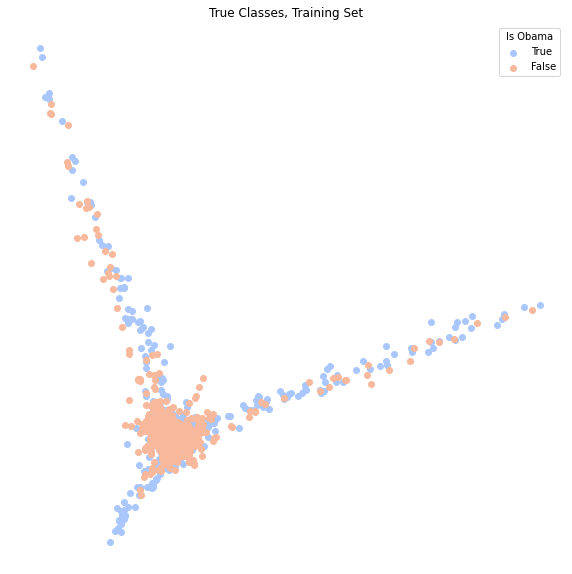

In [30]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

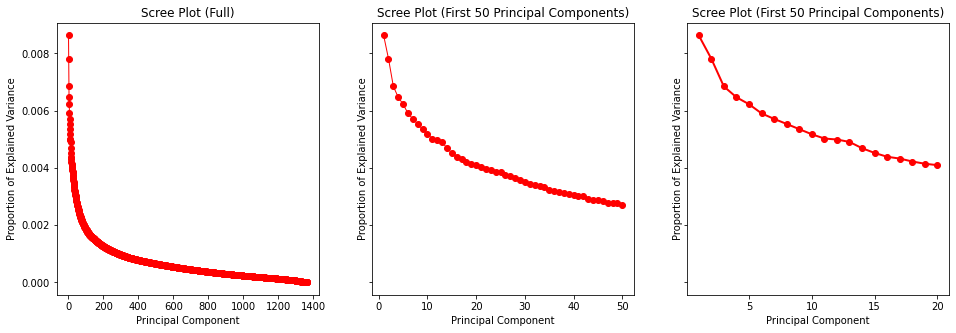

In [31]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [32]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [33]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression()

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [34]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6642282370153622

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [35]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6491228070175439

Slightly poorer. How about using more dimensions (40)?

In [36]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7205559619604974
Testing:
0.7192982456140351


Or still more (100)?

In [37]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8280907095830286
Testing:
0.7923976608187134


Or even more (200)!

In [38]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8734455010972934
Testing:
0.8128654970760234


This is becoming ridiculous (400)!

In [39]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.916605705925384
Testing:
0.827485380116959


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [41]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9634235552304315


Train the model using training data, and then test it on the testing data.

In [42]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8421052631578947


81% accuracy seems like the best we can get by using a logistic regression.

## <font color="red">*Exercise 3*</font>

<font color="red">In the cells immediately following, perform logistic regression classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk in Exercise 1). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [64]:
# relabel the data: positive being +1, negative being -1 and neutral/unknown being 0
survey_data = survey_data.replace(0,-2)
survey_data = survey_data.replace(-1,0)
survey_data = survey_data.replace(-2,-1)
survey_data = survey_data.fillna(-1)
survey_data

,Unnamed: 0,Date,Company,Title,Article,System_GMT_Time,Display_ET_Time,Accession_Number,participant1,participant2,participant3
0,-1,20200401,0,\nNews Highlights: Top Energy News of the Day,\n\n \nOil Rallies But Still Posts Historic Ma...,20200401T040012.298Z,"April 01, 2020 00:00 ET (04:00 GMT)",2.020000e+13,0.0,1.0,-1.0
1,1,20200401,0,\nNews Highlights: Top Financial Services News...,\n\n \nEurope's Banks Urged to Cut Dividends t...,20200401T040012.798Z,"April 01, 2020 00:00 ET (04:00 GMT)",2.020000e+13,0.0,-1.0,-1.0
2,2,20200401,\nUKDAY\n,\nEuropean Morning Briefing: Stock Futures Sli...,\n\n \nSnapshot: \n======== \n\n Stocks seen ...,20200401T040014.736Z,"April 01, 2020 00:00 ET (04:00 GMT)",2.020000e+13,-1.0,1.0,0.0
3,3,20200401,\n7270.TO\nFUJHY\n,\nSubaru: Temporary Suspension to Affect Sever...,\n\n \n\n (MORE TO FOLLOW) Dow Jones Newswire...,20200401T040121.913Z,"April 01, 2020 00:01 ET (04:01 GMT)",2.020000e+13,-1.0,0.0,-1.0
4,4,20200401,\n000488.SZ\n1812.HK\n,\nHK Bourse: Announcement From Shandong Chenmi...,"\n\n \n For full details, please click on t...",20200401T040204.720Z,"April 01, 2020 00:02 ET (04:02 GMT)",2.020000e+13,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
95,95,20200401,\n0653.HK\n,\nHK Bourse: Results Announcement From Bonjour...,"\n\n \n For full details, please click on t...",20200401T041651.825Z,"April 01, 2020 00:16 ET (04:16 GMT)",2.020000e+13,0.0,-1.0,1.0
96,96,20200401,0,\nIndonesia Mar Core Inflation +2.87% On Year ...,\n\n \n\n (MORE TO FOLLOW) Dow Jones Newswire...,20200401T041753.081Z,"April 01, 2020 00:17 ET (04:17 GMT)",2.020000e+13,1.0,0.0,1.0
97,97,20200401,0,\nChina Manufacturing PMI Unlikely to Stay Abo...,\n\n 0418 GMT - China's manufacturing PMI ...,20200401T041905.742Z,"April 01, 2020 00:19 ET (04:19 GMT)",2.020000e+13,-1.0,-1.0,-1.0
98,98,20200401,\n1047.HK\n,\nHK Bourse: Announcement From Ngai Hing Hong ...,\n\n \n Following is the related link: \nht...,20200401T041909.812Z,"April 01, 2020 00:19 ET (04:19 GMT)",2.020000e+13,0.0,0.0,1.0


In [65]:
survey_scores = survey_data.loc[:,['participant1','participant2','participant3']]
survey_scores = survey_scores.astype(int)
survey_scores['average'] = survey_scores.mean(axis=1)

In [66]:
survey_data['sentiment'] = [s>0 for s in survey_scores['average']]

In [68]:
survey_data['tokenized_text'] = survey_data['Article'].apply(lambda x: lucem_illud.word_tokenize(x))
survey_data['normalized_text'] = survey_data['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [69]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(survey_data, test_size=holdBackFraction)

In [70]:
print(len(train_data_df))
print(len(test_data_df))

80
20


In [71]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['Article'])

In [72]:
TFVects.shape

(80, 2394)

In [73]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In [74]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

In [75]:
train_data_df['pca'] = [r for r in reduced_data]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


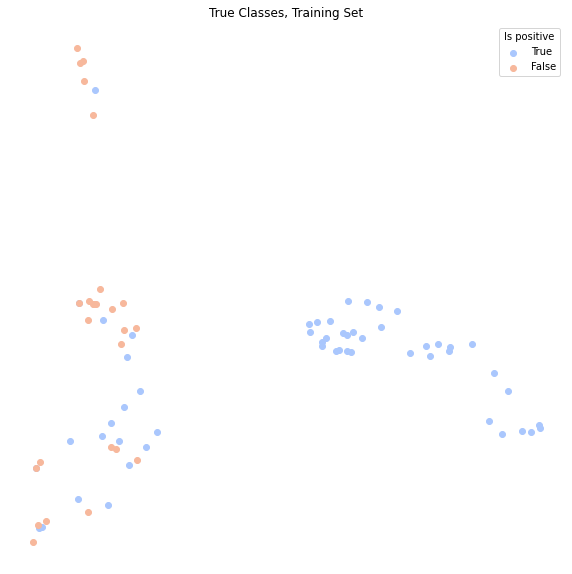

In [77]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['sentiment']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['sentiment'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is positive')
plt.title('True Classes, Training Set')
plt.show()

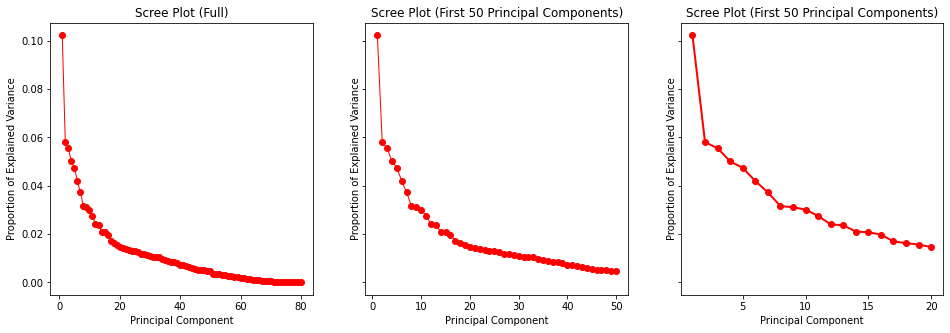

In [78]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [79]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [80]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['sentiment'])

LogisticRegression()

In [83]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['sentiment'])

0.825

In [81]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['Article'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['sentiment'])

0.7

Testing accuracy is slightly poorer. 

In [86]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['sentiment'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['sentiment']))

0.875


In [85]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['sentiment']))

0.7


The test accuracy is 0.7.

In [91]:
def evaluateClassifier(clf, testDF):
    predictions = clf.predict(np.stack(testDF['vect'], axis=0))
    classes = []
    results = {
        'Error_Rate' : [],
        'AUC' : [],
        'Precision' : [],
        'Average_Precision' : [],
        'Recall' : [],
        }

    for cat in set(testDF['sentiment']):
        preds = [True if (c == cat) else False for c in predictions]
        acts = [True if (c == cat) else False for c in testDF['sentiment']]
        classes.append(cat)
        results['AUC'].append(sklearn.metrics.roc_auc_score(acts, preds))
        results['Average_Precision'].append(sklearn.metrics.average_precision_score(acts, preds))
        results['Precision'].append(sklearn.metrics.precision_score(acts, preds))
        results['Recall'].append(sklearn.metrics.recall_score(acts, preds))
        results['Error_Rate'].append(1 -  sklearn.metrics.accuracy_score(acts, preds))
    df = pandas.DataFrame(results, index=classes)
    df.index.rename('Category', inplace=True)
    return df

In [92]:
evaluateClassifier(logistic_l1, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.3,0.625,1.000000,0.550000,0.25
True,0.3,0.625,0.666667,0.666667,1.00


In [95]:
def plotConfusionMatrix(clf, testDF):
    predictions = clf.predict(np.stack(testDF['vect'], axis=0))
    mat = sklearn.metrics.confusion_matrix(testDF['sentiment'], predictions)
    seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                    xticklabels=testDF['sentiment'].unique(), yticklabels=testDF['sentiment'].unique())
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.title("Confusion Matrix")
    plt.show()
    plt.close()

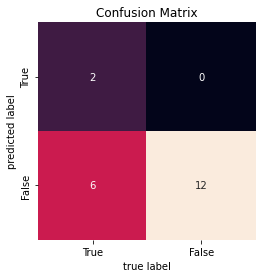

In [96]:
plotConfusionMatrix(logistic_l1, test_data_df)

In [98]:
def plotMultiROC(clf, testDF):
    #By making the column names variables we can easily use this function on new data sets

    #Get the names of each of the possible classes and the probabiltiess
    classes = clf.classes_
    try:
        probs = clf.predict_proba(np.stack(testDF['vect'], axis=0))
    except AttributeError:
        print("The {} classifier does not apear to support prediction probabilties, so an ROC curve can't be created. You can try adding `probability = True` to the model specification or use a different model.".format(type(clf)))
        return
    predictions = clf.predict(np.stack(testDF['vect'], axis=0))

    #setup axis for plotting
    fig, ax = plt.subplots(figsize = (10,10))

    #We can return the AUC values, in case they are useful
    aucVals = []
    for classIndex, className in enumerate(classes):        #Setup binary classes
        truths = [1 if c == className else 0 for c in testDF['sentiment']]
        predict = [1 if c == className else 0 for c in predictions]
        scores = probs[:, classIndex]

        #Get the ROC curve
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(truths, scores)
        auc = sklearn.metrics.auc(fpr, tpr)
        aucVals.append(auc)

        #Plot the class's line
        ax.plot(fpr, tpr, label = "{} (AUC ${:.3f}$)".format(str(className).split(':')[0], auc))

    #Make the plot nice, then display it
    ax.set_title('Receiver Operating Characteristics')
    plt.plot([0,1], [0,1], color = 'k', linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc = 'lower right')
    plt.show()
    plt.close()
    #return aucVals


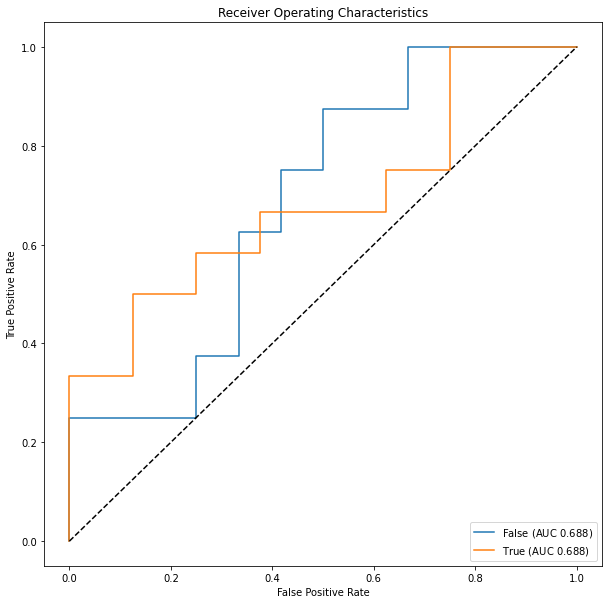

In [99]:
plotMultiROC(logistic_l1, test_data_df)

In [112]:
def plotregions(clf, df, h = .01):
    if np.random.choice(df['vect']).shape[0] > 2:
        pca = sklearn.decomposition.PCA(n_components = 2)
        reduced_data = pca.fit_transform(np.stack(df['vect'], axis=0))
        transformedDF = pandas.DataFrame({'vect' : [r for r in reduced_data], 'category' : df['sentiment']})
    else:
        transformedDF = df
    catsMap = {c : i for i, c in enumerate(np.unique(df['sentiment']))}

    fig, ax = plt.subplots(figsize = (10,10))
    ax.axis('off')
    pallet = seaborn.color_palette(palette='coolwarm', n_colors = len(set(transformedDF['category'])))

    if np.random.choice(df['vect']).shape[0] > 2:
        xx, yy = np.meshgrid(np.arange(1.1 * reduced_data[:,0].min(),
                1.1 * reduced_data[:,0].max(), h),
            np.arange(1.1 * reduced_data[:,1].min(),
                1.1 * reduced_data[:,1].max(), h))
        Z = clf.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    else:
        reduced_data = np.stack(df['vect'], axis=0)
        xx, yy = np.meshgrid(np.arange(1.1 * reduced_data[:,0].min(),
                1.1 * reduced_data[:,0].max(), h),
            np.arange(1.1 * reduced_data[:,1].min(),
                1.1 * reduced_data[:,1].max(), h))

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.vectorize(lambda x: catsMap[x])(Z)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)
    for i, cat in enumerate(set(df['sentiment'])):
        a = np.stack(transformedDF[transformedDF['category'] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    plt.show()
    plt.close()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


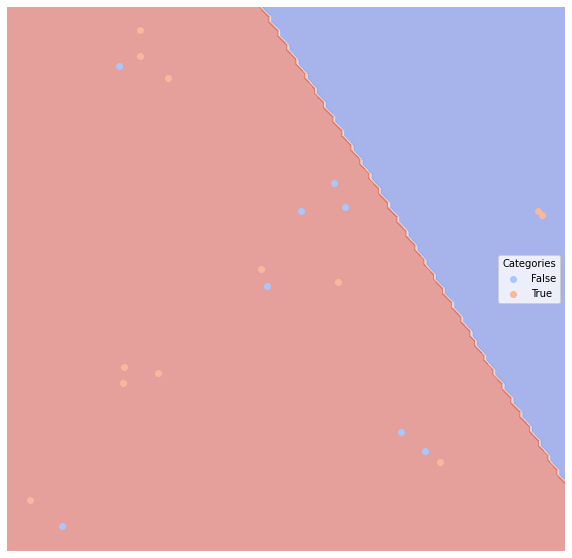

In [113]:
plotregions(logistic_l1, test_data_df)

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

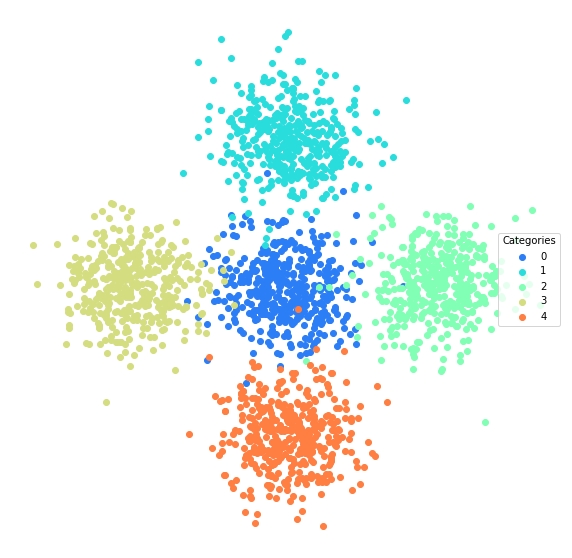

In [100]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = sklearn.model_selection.train_test_split(blobs_df, test_size=.2)
lucem_illud.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [101]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

To see what's going on visually with the classification: 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

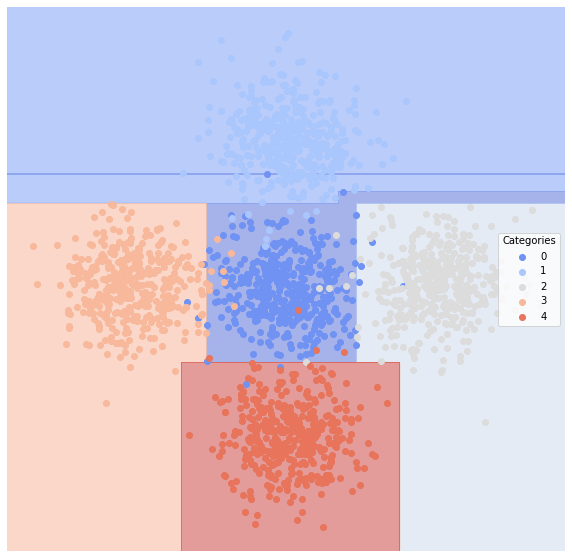

In [102]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [104]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.026,0.963022,0.915789,0.876018,0.945652
1,0.010,0.982918,0.980392,0.957837,0.970874
2,0.006,0.992364,0.979592,0.971493,0.989691
3,0.008,0.984960,0.990654,0.969388,0.972477
4,0.010,0.982355,0.979592,0.955907,0.969697


Lets look at accuracy:

In [105]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.97

What happens if we trim the tree?

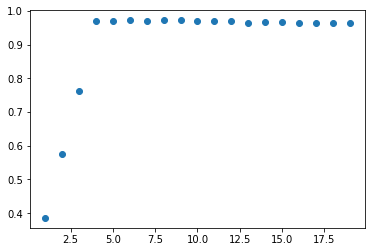

In [106]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [107]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [108]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

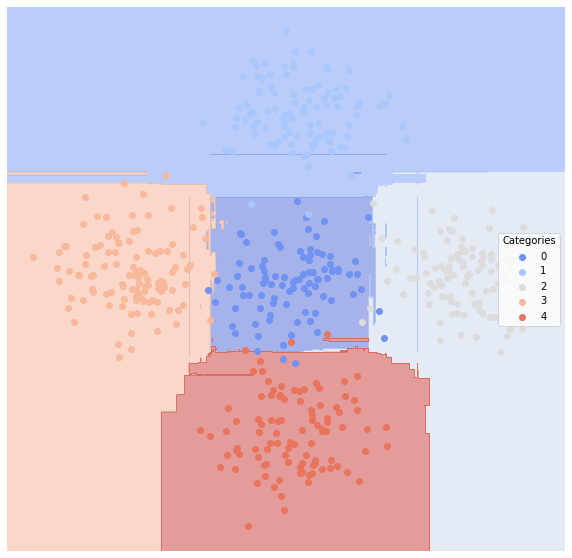

In [109]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [110]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.022,0.965473,0.935484,0.894642,0.945652
1,0.006,0.989032,0.990196,0.974969,0.980583
2,0.006,0.992364,0.979592,0.971493,0.989691
3,0.004,0.994134,0.990826,0.983736,0.990826
4,0.010,0.982355,0.979592,0.955907,0.969697


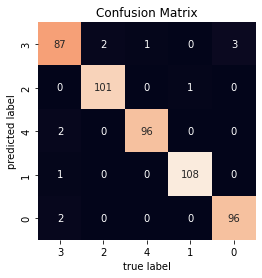

In [111]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <font color="red">*Exercise 4*</font>

<font color="red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

In [115]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['sentiment'])

DecisionTreeClassifier(max_depth=4, random_state=0)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


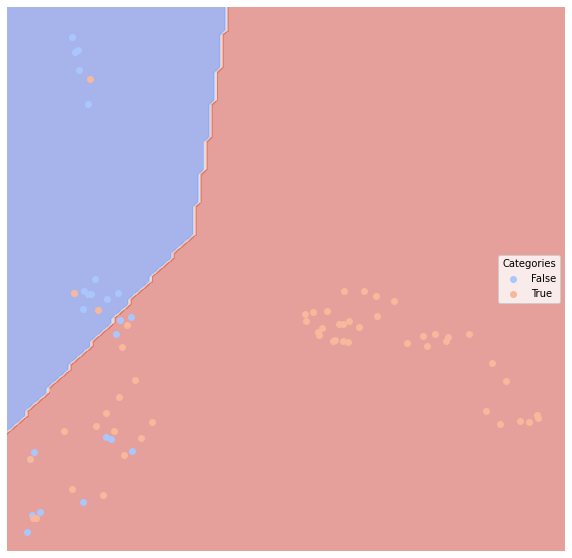

In [116]:
plotregions(clf_tree, train_data_df)

In [117]:
evaluateClassifier(clf_tree, train_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.0625,0.953704,0.83871,0.838710,1.000000
True,0.0625,0.953704,1.00000,0.969907,0.907407


In [118]:
sklearn.metrics.accuracy_score(test_data_df['sentiment'],clf_tree.predict(np.stack(test_data_df['vect'], axis = 0)))

0.7

We can trim the tree:

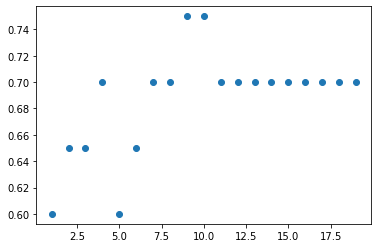

In [119]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['sentiment'])
    score = sklearn.metrics.accuracy_score(test_data_df['sentiment'], tree2.predict(np.stack(test_data_df['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

In [120]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [121]:
bag.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['sentiment']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


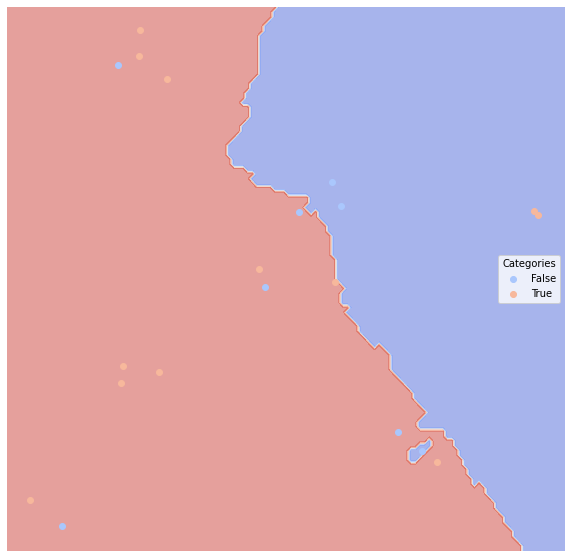

In [123]:
plotregions(bag, test_data_df)

In [124]:
evaluateClassifier(bag, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.3,0.708333,0.6,0.550000,0.750000
True,0.3,0.708333,0.8,0.733333,0.666667


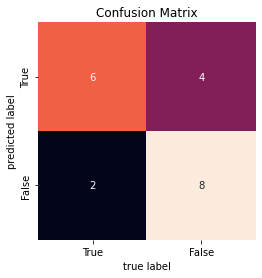

In [125]:
plotConfusionMatrix(bag, test_data_df)

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.

In [ ]:
newsgroupsDF[:5]

Make a testing and training set:

In [ ]:
holdBackFraction = .2
train_ng_df, test_ng_df = sklearn.model_selection.train_test_split(newsgroupsDF, test_size=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [ ]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [ ]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [ ]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

And lets look at the testing data

In [ ]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Let's produce another confusion matrix:

In [ ]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud.plotregions(clf_knearest, test_ng_df)

## <font color="red">*Exercise 5*</font>

<font color="red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [126]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

In [128]:
clf_knearest.fit(np.stack(train_data_df['vect'], axis = 0), train_data_df['sentiment'])

KNeighborsClassifier(n_neighbors=15)

In [129]:
evaluateClassifier(clf_knearest, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.4,0.583333,0.500000,0.450000,0.500000
True,0.4,0.583333,0.666667,0.644444,0.666667


In [131]:
print("Testing score:")
print(clf_knearest.score(np.stack(test_data_df['vect'], axis=0), test_data_df['sentiment']))

Testing score:
0.6


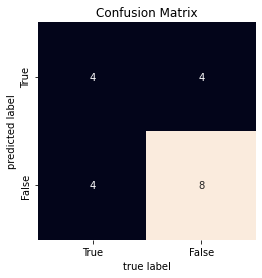

In [132]:
plotConfusionMatrix(clf_knearest, test_data_df)

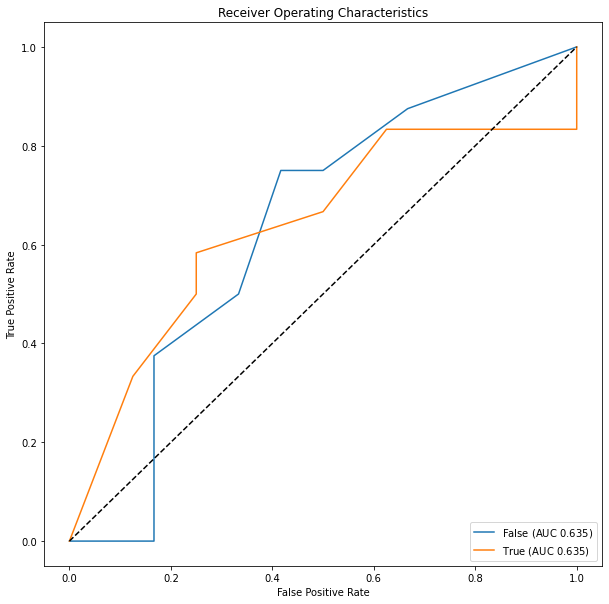

In [133]:
plotMultiROC(clf_knearest, test_data_df)

K-means clustering represents an unsupervised algorithm, mainly used for clustering, while KNN is a supervised learning algorithm used for classification.

On the one hand, KNN represents a supervised classification algorithm. It gives new data points accordingly to the K number or the closest data points. On the other hand K-means clustering is an unsupervised clustering algorithm. It groups data into K number of clusters.

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [ ]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [ ]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [ ]:
holdBackFraction = .2
train_redditDf, test_redditDf = sklearn.model_selection.train_test_split(redditDf, test_size=holdBackFraction)

In [ ]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

...and consider the results:

In [ ]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

In [ ]:
evaluateClassifier(clf_nn, test_redditDf)

In [ ]:
plotConfusionMatrix(clf_nn, test_redditDf)

In [ ]:
plotregions(clf_nn, test_redditDf)

It performs very well.

## <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, logistic and decision-tree approaches?

In [134]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['sentiment'])

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier()

In [135]:
evaluateClassifier(clf_nn, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.35,0.666667,0.545455,0.509091,0.750000
True,0.35,0.666667,0.777778,0.703704,0.583333


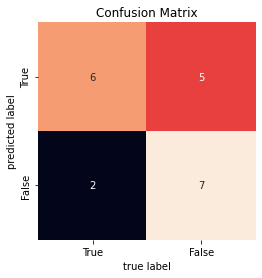

In [137]:
plotConfusionMatrix(clf_nn, test_data_df)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


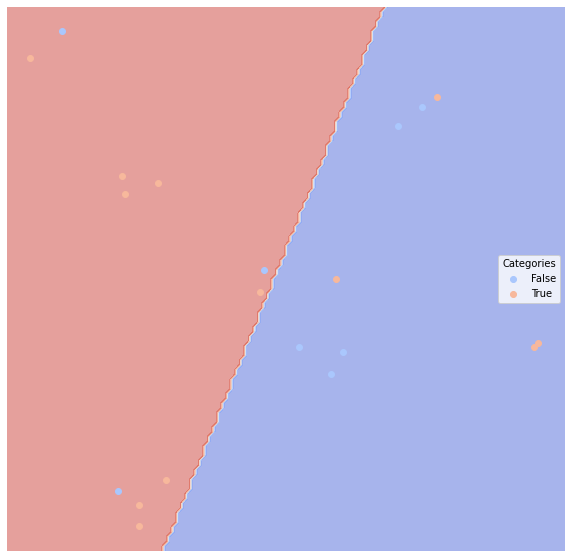

In [138]:
plotregions(clf_nn, test_data_df)

It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers.The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

### Sequence Classification (e.g., sentiment)
Sequence classification is the task of classifying sequences according to a given number of classes. An example of
sequence classification is the GLUE dataset. If you would like to fine-tune a
model on a GLUE sequence classification task, you may leverage the [run_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_glue.py) and
[run_pl_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_pl_glue.py) or
[run_tf_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_tf_glue.py) scripts.

Here is an example of using pipelines to do sentiment analysis: identifying if a sentence is positive or negative. It
leverages a fine-tuned model on sst2, which is a GLUE task.

This returns a label ("POSITIVE" or "NEGATIVE") alongside a score, as follows:

In [140]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 4.3 MB/s 
     |████████████████████████████████| 6.8 MB 42.8 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
     |████████████████████████████████| 596 kB 45.2 MB/s 
     |████████████████████████████████| 895 kB 45.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [141]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")
result = nlp("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
result = nlp("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

label: NEGATIVE, with score: 0.9991
label: POSITIVE, with score: 0.9999


Here is an example of doing a sequence classification using a model to determine if two sequences are paraphrases of
each other. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Build a sequence from the two sentences, with the correct model-specific separators token type ids and attention
   masks (`PreTrainedTokenizer.encode` and `PreTrainedTokenizer.__call__` take
   care of this).
3. Pass this sequence through the model so that it is classified in one of the two available classes: 0 (not a
   paraphrase) and 1 (is a paraphrase).
4. Compute the softmax of the result to get probabilities over the classes.
5. Print the results.

In [142]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")
classes = ["not paraphrase", "is paraphrase"]
sequence_0 = "The company HuggingFace is based in New York City"
sequence_1 = "Apples are especially bad for your health"
sequence_2 = "HuggingFace's headquarters are situated in Manhattan"
paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")
paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits
paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]
# Should be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")
# Should not be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/413M [00:00<?, ?B/s]

not paraphrase: 10%
is paraphrase: 90%
not paraphrase: 94%
is paraphrase: 6%


### Extractive Question Answering

Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune a
model on a SQuAD task, you may leverage the [run_squad.py](https://github.com/huggingface/transformers/tree/master/examples/question-answering/run_squad.py) and
[run_tf_squad.py](https://github.com/huggingface/transformers/tree/master/examples/question-answering/run_tf_squad.py) scripts.


Here is an example of using pipelines to do question answering: extracting an answer from a text given a question. It
leverages a fine-tuned model on SQuAD.

In [143]:
from transformers import pipeline
nlp = pipeline("question-answering")
context = r"""
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the examples/question-answering/run_squad.py script.
"""

No model was supplied, defaulted to distilbert-base-cased-distilled-squad (https://huggingface.co/distilbert-base-cased-distilled-squad)


Downloading:   0%|          | 0.00/473 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/249M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

This returns an answer extracted from the text, a confidence score, alongside "start" and "end" values, which are the
positions of the extracted answer in the text.

In [144]:
result = nlp(question="What is extractive question answering?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")
result = nlp(question="What is a good example of a question answering dataset?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'the task of extracting an answer from a text given a question', score: 0.6226, start: 34, end: 95
Answer: 'SQuAD dataset', score: 0.5053, start: 147, end: 160


Here is an example of question answering using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Define a text and a few questions.
3. Iterate over the questions and build a sequence from the text and the current question, with the correct
   model-specific separators token type ids and attention masks.
4. Pass this sequence through the model. This outputs a range of scores across the entire sequence of tokens (question and
   text), for both the start and end positions.
5. Compute the softmax of the result to get probabilities over the tokens.
6. Fetch the tokens from the identified start and stop values, convert those tokens to a string.
7. Print the results.

In [145]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""
questions = [
    "How many pretrained models are available in 🤗 Transformers?",
    "What does 🤗 Transformers provide?",
    "🤗 Transformers provides interoperability between which frameworks?",
]
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Question: How many pretrained models are available in 🤗 Transformers?
Answer: over 32 +
Question: What does 🤗 Transformers provide?
Answer: general - purpose architectures
Question: 🤗 Transformers provides interoperability between which frameworks?
Answer: tensorflow 2. 0 and pytorch


## <font color="red">*Exercise 7*</font>

<font color="red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

In [158]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")
result = nlp(survey_data['Article'][1])[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
result = nlp(survey_data['Article'][3])[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


label: NEGATIVE, with score: 0.9983
label: NEGATIVE, with score: 0.868


The BERT model is very useful when classifying the sentiments of financial news articles. BERT is advantageous since it is based on Transformers, a deep learning model in which every output element is connected to every input element, and the weightings between them are dynamically calculated based upon their connection.

BERT model can both read text input in two directions - left-to-right and right-to-left at once. This feature is especially helpful in sentiment classification.